<a href="https://colab.research.google.com/github/f5tihyahya/portofolio/blob/main/%5BGRU%5D_BMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install lib

In [ ]:
!pip install mplfinance

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


#EDA

In [ ]:
linkcsv = "https://drive.google.com/file/d/1DO6nc2uoMc1yrjK0W1D0UTTjk_f5k5pC/view?usp=sharing"
linkcsv = 'https://drive.google.com/uc?id=' + linkcsv.split('/')[-2]
bmri = pd.read_csv(linkcsv)

In [ ]:
bmri['Date']=pd.to_datetime(bmri['Date'])

In [ ]:
bmri.shape

(1201, 6)

In [ ]:
bmri.head()

,Date,Open,High,Low,Close,Volume
0,2020-08-18 00:00:00+07:00,2286.725530,2362.633432,2286.725530,2334.167969,115981200
1,2020-08-19 00:00:00+07:00,2343.656627,2372.122092,2305.702674,2315.191162,64511800
2,2020-08-24 00:00:00+07:00,2296.214036,2343.656475,2248.771597,2277.237061,132486400
3,2020-08-25 00:00:00+07:00,2296.214164,2381.610559,2296.214164,2372.122070,132365800
4,2020-08-26 00:00:00+07:00,2372.121976,2410.075928,2343.656512,2410.075928,78703400


In [ ]:
bmri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype                    
---  ------  --------------  -----                    
 0   Date    1201 non-null   datetime64[ns, UTC+07:00]
 1   Open    1201 non-null   float64                  
 2   High    1201 non-null   float64                  
 3   Low     1201 non-null   float64                  
 4   Close   1201 non-null   float64                  
 5   Volume  1201 non-null   int64                    
dtypes: datetime64[ns, UTC+07:00](1), float64(4), int64(1)
memory usage: 56.4 KB


In [ ]:
bmri.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [ ]:
bmri.duplicated().sum()

np.int64(0)

In [ ]:
bmri

,Date,Open,High,Low,Close,Volume
0,2020-08-18 00:00:00+07:00,2286.725530,2362.633432,2286.725530,2334.167969,115981200
1,2020-08-19 00:00:00+07:00,2343.656627,2372.122092,2305.702674,2315.191162,64511800
2,2020-08-24 00:00:00+07:00,2296.214036,2343.656475,2248.771597,2277.237061,132486400
3,2020-08-25 00:00:00+07:00,2296.214164,2381.610559,2296.214164,2372.122070,132365800
4,2020-08-26 00:00:00+07:00,2372.121976,2410.075928,2343.656512,2410.075928,78703400
...,...,...,...,...,...,...
1196,2025-08-11 00:00:00+07:00,4710.000000,4780.000000,4700.000000,4720.000000,105204200
1197,2025-08-12 00:00:00+07:00,4770.000000,4920.000000,4750.000000,4910.000000,301599000
1198,2025-08-13 00:00:00+07:00,4930.000000,4970.000000,4860.000000,4870.000000,180844900
1199,2025-08-14 00:00:00+07:00,4910.000000,4930.000000,4840.000000,4850.000000,109457100


In [ ]:
# bmri=bmri.reset_index()
# candlestick
fig = go.Figure(data=[go.Candlestick(
    x=bmri['Date'],
    open=bmri['Open'],
    high=bmri['High'],
    low=bmri['Low'],
    close=bmri['Close'],
    name="BMRI"
)])

# tambahkan volume di bawah chart
fig.add_trace(go.Bar(
    x=bmri['Date'],
    y=bmri['Volume'],
    name='Volume',
    marker_color='black',
    opacity=0.8,
    yaxis="y2"
))

# layout dengan 2 axis (price + volume)
fig.update_layout(
    title="BMRI Candlestick (Interactive)",
    xaxis=dict(rangeslider=dict(visible=False)), # sembunyikan rangeslider default
    yaxis=dict(title="Price"),
    yaxis2=dict(title="Volume", overlaying="y", side="right", showgrid=False)
)

fig.show()


#preprocessing

In [ ]:
data = bmri.copy()
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Ambil fitur (OHLCV) & target (Close)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
# data = df[features].values

# Normalisasi biar training lebih stabil
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(data)

In [ ]:
values = data.values

train_size = int(len(values) * 0.85)
train_data = values[:train_size]
test_data  = values[train_size:]

# scaling pakai train saja supaya tidak "bocor"
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled  = scaler.transform(test_data)

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])      # input window
        y.append(data[i+seq_length])     # target = kolom "Close" (index 3)
    return np.array(X), np.array(y)

seq_length = 20
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test   = create_sequences(test_scaled, seq_length)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=10, shuffle=False)


#model declaration

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=80, num_layers=10, output_size=5, dropout=0.2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # output = 1 (Close Price)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # ambil hidden state terakhir
        out = self.fc(out)
        return out


#training

In [ ]:
model = GRUModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00015)

berapa_kali = 100 #<<---------------------EPOCHs-------------------
for epoch in range(berapa_kali):  # misalnya 20 epoch
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_batch = y_batch.squeeze(1)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")
    # if epoch == 0:
    #     print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")
    # elif epoch%5 == 0:
    #     print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

Epoch 1, Train Loss: 0.007538924877298996
Epoch 2, Train Loss: 0.057690168833360075
Epoch 3, Train Loss: 0.0808828421041835
Epoch 4, Train Loss: 0.08217138901818544
Epoch 5, Train Loss: 0.019086259125033395
Epoch 6, Train Loss: 0.009494860274135136
Epoch 7, Train Loss: 0.00908708074304741
Epoch 8, Train Loss: 0.006304830519366078
Epoch 9, Train Loss: 0.006763540066895075
Epoch 10, Train Loss: 0.007389511858345941
Epoch 11, Train Loss: 0.007727031843387522
Epoch 12, Train Loss: 0.008228364957030863
Epoch 13, Train Loss: 0.008359475957695395
Epoch 14, Train Loss: 0.009181307810358703
Epoch 15, Train Loss: 0.009579407647252083
Epoch 16, Train Loss: 0.009418137090397067
Epoch 17, Train Loss: 0.009700959115871228
Epoch 18, Train Loss: 0.009707480510114693
Epoch 19, Train Loss: 0.0097345161694102
Epoch 20, Train Loss: 0.009899474349222146
Epoch 21, Train Loss: 0.010251371871563606
Epoch 22, Train Loss: 0.010238683820934966
Epoch 23, Train Loss: 0.009907991472282447
Epoch 24, Train Loss: 0.00

In [ ]:
X_batch.shape

torch.Size([10, 20, 5])

#eval

In [ ]:
model.eval()
test_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        pred = model(X_batch)
        test_preds.append(pred.detach().cpu().numpy())

# test_preds = np.concatenate(test_preds).flatten()
test_preds = np.concatenate(test_preds, axis=0)
test_preds_asli = scaler.inverse_transform(test_preds)


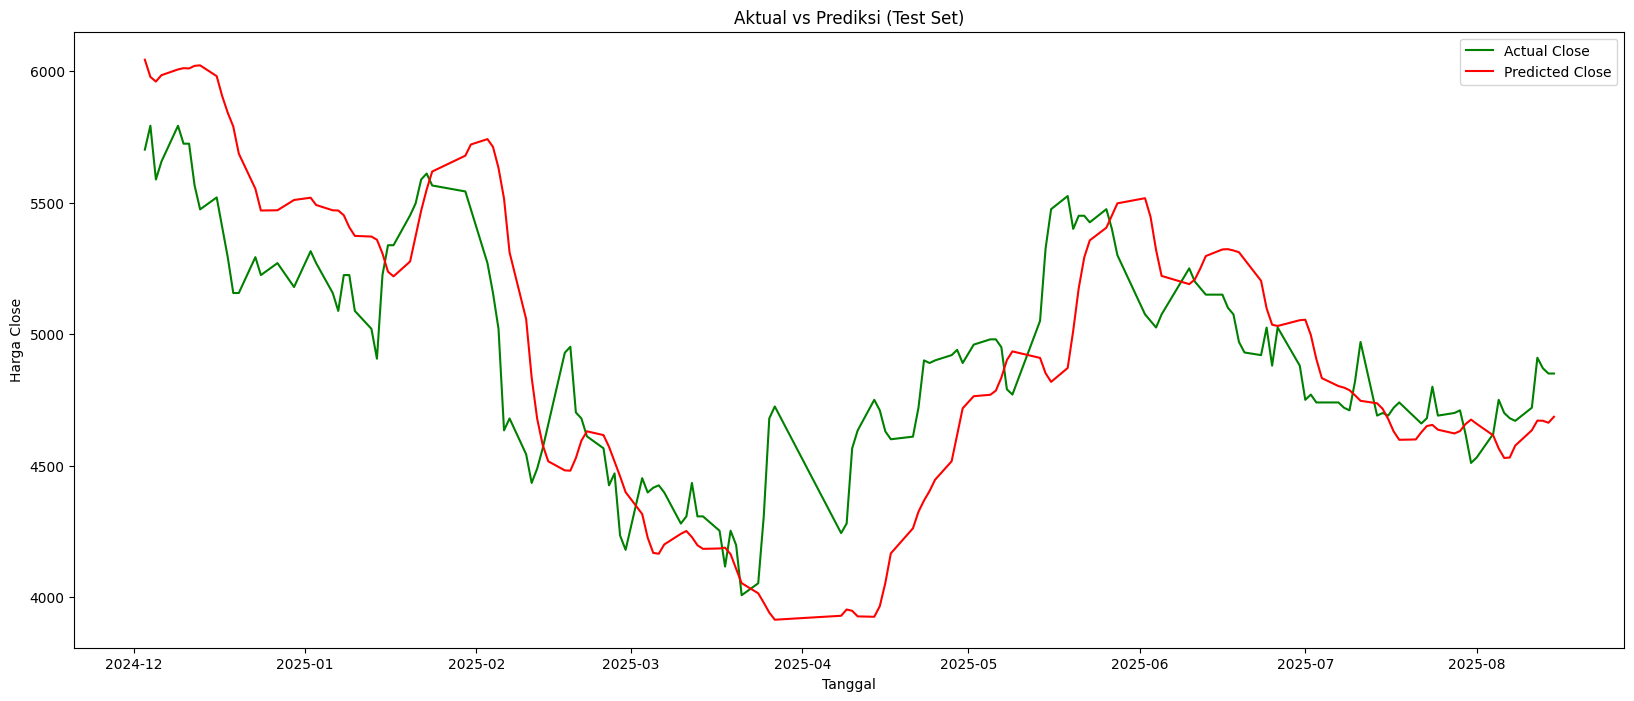

MSE  : 99300.1165
MAE  : 248.2215
MAPE : 99.99%


In [ ]:
# ambil data actual test (Close dalam skala asli)
dummy_true = np.zeros((len(y_test), train_scaled.shape[1]))
dummy_true[:, 3] = y_test[:, 3]   # ambil hanya kolom Close
y_test_asli = scaler.inverse_transform(dummy_true)[:, 3]

# indeks tanggal untuk test set
test_index = data.index[train_size+seq_length:]  # sesuaikan dengan slicing kamu

y_pred_asli = test_preds_asli[:, 3]

plt.figure(figsize=(20,8))
plt.plot(test_index, y_test_asli, label="Actual Close", color='green')
plt.plot(test_index, y_pred_asli, label="Predicted Close", color='red')  # kolom Close
plt.legend()
plt.title("Aktual vs Prediksi (Test Set)")
plt.xlabel("Tanggal")
plt.ylabel("Harga Close")
plt.show()

mse = mean_squared_error(y_test_asli, y_pred_asli)

# MAE
mae = mean_absolute_error(y_test_asli, y_pred_asli)

# MAPE
mape = np.mean(np.abs((y_test_asli, y_pred_asli) / y_test_asli)) * 100

print(f"MSE  : {mse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")

#forecast

In [ ]:
df = bmri.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].values

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
def predict_until(model, data_scaled, seq_length, scaler, last_date, end_date="2025-12-31"):
    model.eval()

    # pastikan end_date punya timezone yang sama dengan last_date
    if last_date.tz is not None:
        end_date = pd.Timestamp(end_date).tz_localize(last_date.tz)
    else:
        end_date = pd.Timestamp(end_date)

    # generate tanggal bursa (senin-jumat)
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), end=end_date, freq="C")

    predictions = []
    cur_seq = torch.tensor(data_scaled[-seq_length:], dtype=torch.float32).unsqueeze(0)  # (1, seq_len, 5)

    for _ in range(len(future_dates)):
        with torch.no_grad():
            pred = model(cur_seq)
            pred = pred.cpu().numpy()
            predictions.append(pred[0])

        # update sequence dengan prediksi baru
        new_row = torch.tensor(pred, dtype=torch.float32)  # (1, 5)
        new_row = new_row.unsqueeze(0)  # (1,1,5)
        cur_seq = torch.cat((cur_seq[:, 1:, :], new_row), dim=1)



    predictions = np.array(predictions)


    future_preds = scaler.inverse_transform(predictions)

    return future_dates, future_preds


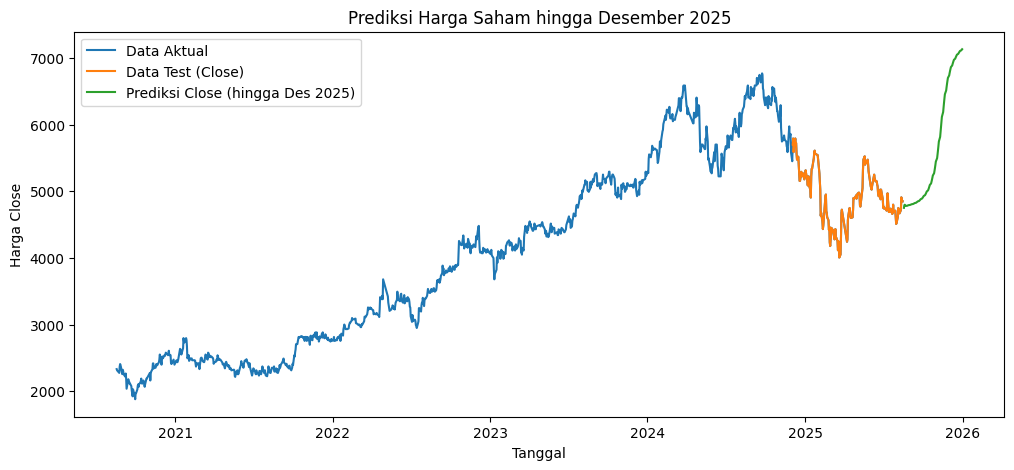

In [ ]:
last_date = df.index[-1]
future_dates, future_preds = predict_until(model, data_scaled, seq_length=100, scaler=scaler, last_date=last_date)


dummy_true = np.zeros((len(y_test), train_scaled.shape[1]))
dummy_true[:, 3] = y_test[:, 3]   #  kolom 3 = Close
y_test_asli = scaler.inverse_transform(dummy_true)[:, 3]


test_index = df.index[train_size+seq_length:]

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label="Data Aktual")
plt.plot(test_index, y_test_asli, label="Data Test (Close)")
plt.plot(future_dates, future_preds[:, 3], label="Prediksi Close (hingga Des 2025)")
plt.legend()
plt.xlabel("Tanggal")
plt.ylabel("Harga Close")
plt.title("Prediksi Harga Saham hingga Desember 2025")
plt.show()
